# Clustering

In [2]:
import pandas as pd
import numpy as np
# import logging
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, euclidean
import math
import datetime
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
emissions = pd.read_csv("df_dh_emissions.csv", index_col=0)
emissions["started_on_date"] = pd.to_datetime(emissions["started_on_date"], utc=True)
driver_gb = emissions.groupby("driver_id")
date_gb = emissions.groupby("started_on_date")

___

Text(0, 0.5, 'Count')

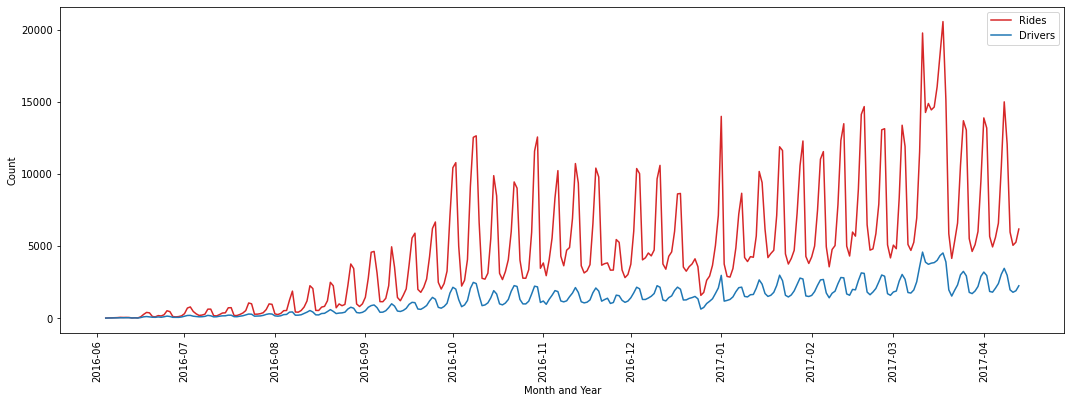

In [4]:
plt.plot(date_gb.count()[["driver_id"]].index, date_gb.sum()["num_rides"], color='tab:red', label="Rides")
plt.plot(date_gb.count()[["driver_id"]].index, date_gb.count()["driver_id"], color='tab:blue', label="Drivers")
plt.xticks(rotation='vertical')
plt.legend()
plt.xlabel("Month and Year")
plt.ylabel("Count")
# plt.tight_layout()
# plt.savefig('eda_counts.png', dpi=200)

In [5]:
car_var = pd.Series(driver_gb.max()[['high_eff', 'avg_eff', 'poor_eff']].columns[np.where(driver_gb.max()[['high_eff', 'avg_eff', 'poor_eff']]!=0)[1]], name="efficiency")
car_var.replace({"poor_eff": "Poor", "avg_eff": "Average", "high_eff": "High"}, inplace=True)
car_var.head()

0       Poor
1       Poor
2       Poor
3    Average
4    Average
Name: efficiency, dtype: object

[Text(0.5, 0, 'Total Number of Rides'),
 Text(0, 0.5, 'Total Emissions (Tailpipe CO2 in Grams/Mile)')]

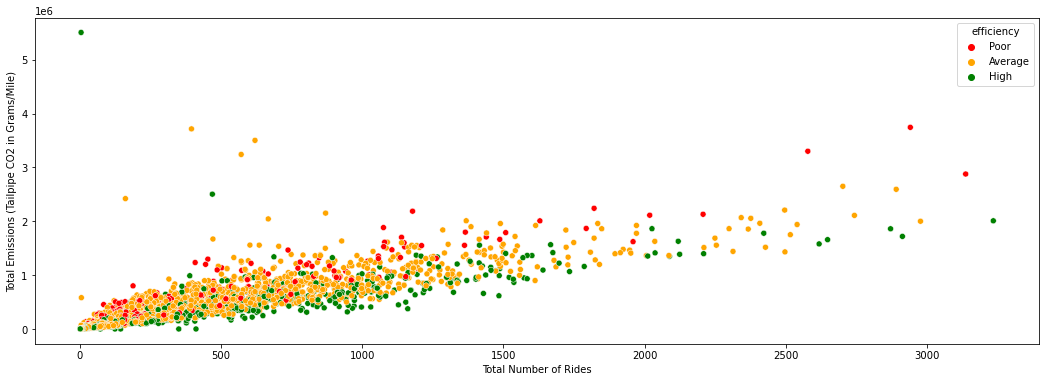

In [7]:
summed = driver_gb.sum()
summed["efficiency"] = car_var
clr_map = {'High': 'green', 'Average': 'orange', 'Poor': 'red'}
ax = sns.scatterplot(x="num_rides", y="total_emissions", data=summed, hue="efficiency", palette=clr_map, legend="full")
ax.set(xlabel='Total Number of Rides', ylabel='Total Emissions (Tailpipe CO2 in Grams/Mile)')
# plt.tight_layout()
# plt.savefig('sort_by_eff.png', dpi=200)

## Import Data with Zipcodes

In [15]:
df = pd.read_csv('with_zipcodes.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (28,29,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df['zipcode'] = df['zipcode'].apply(lambda z: str(z)[:5] if not pd.isna(z) else np.nan)

___

In [17]:
original_len = df.shape[0]

# Conservatively estimated bounding box around Austin, TX
df = df[~(
    (df['start_location_lat'] < 25) |
    (df['start_location_lat'] > 35) |
    (df['start_location_long'] < -100) |
    (df['start_location_long'] > -90)
)]

print('{} outliers removed.'.format(original_len - df.shape[0]))

4 outliers removed.


Find Bounding Box for Austin, TX

In [18]:
lats = df[df['start_location_lat'].between(df['start_location_lat'].quantile(.05), df['start_location_lat'].quantile(.95))]['start_location_lat']
longs = df[df['start_location_long'].between(df['start_location_long'].quantile(.05), df['start_location_long'].quantile(.95))]['start_location_long']

BBox = (longs.min(), longs.max(), lats.min(), lats.max())
print('Bounding Box around Austin Ride Area: {}'.format(BBox))

Bounding Box around Austin Ride Area: (-97.801, -97.668, 30.202, 30.4)


___

In [19]:
# Source: https://www.openstreetmap.org/export#map=12/30.3010/-97.7345
austin_map = plt.imread('austin_map.png')

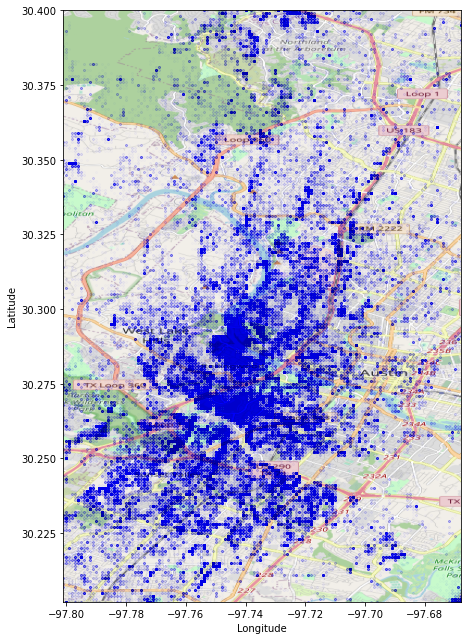

In [22]:
fig, ax = plt.subplots(figsize = (20,9))
ax.scatter(df.start_location_long, df.start_location_lat, zorder=1, alpha= 0.01, c='b', s=5)
#ax.set_title('Plotting Spatial Data on Austin Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.imshow(austin_map, zorder=0, extent = BBox, aspect= 'equal')
plt.tight_layout()
plt.savefig("ride_start.png", dpi=200)

In [23]:
df = df[~(
    (df['start_location_lat'] < 30.202) |
    (df['start_location_lat'] > 30.4) |
    (df['start_location_long'] < -97.801) |
    (df['start_location_long'] > -97.668)
)]

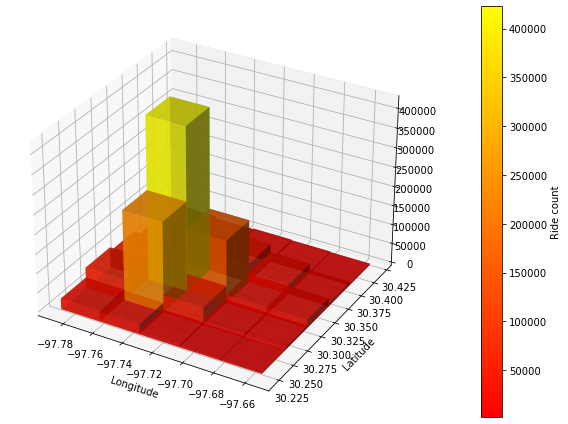

In [27]:
xAmplitudes = df.start_location_long
yAmplitudes = df.start_location_lat

x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
y = np.array(yAmplitudes)

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
hist, xedges, yedges = np.histogram2d(x.T, y.T, bins=(5,5))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like(xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = plt.cm.get_cmap('autumn') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
norm = mpl.colors.Normalize(vmin=min_height, vmax=max_height)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average', alpha=0.7)
# plt.title("Locations of s")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap = 'autumn'), ax = ax)
cbar.set_label("Ride count")


plt.tight_layout()
plt.savefig("hist3d", dpi=200)
plt.show()

___

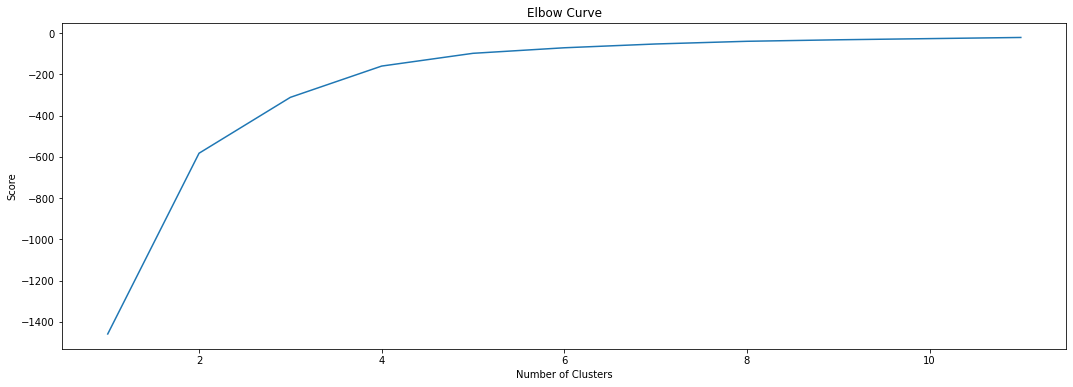

In [75]:
K_clusters = range(1, 12)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['start_location_lat']]
X_axis = df[['start_location_long']]

score = []

for i in range(len(kmeans)):
    kmeans_score = kmeans[i].fit(Y_axis).score(Y_axis)
    score.append(kmeans_score)
    
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [28]:
num_clusters = 10

In [29]:
X = df[['RIDE_ID', 'start_location_lat', 'start_location_long']]

In [30]:
kmeans = KMeans(n_clusters = num_clusters, init ='k-means++')

kmeans.fit(X[['start_location_lat', 'start_location_long']]) 
X['zone_label'] = kmeans.fit_predict(X[['start_location_lat', 'start_location_long']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
centers = kmeans.cluster_centers_
center_dict = {ind: pt for ind, pt in enumerate(centers)}

{0: array([ 30.31826739, -97.71212397]),
 1: array([ 30.26655238, -97.76837643]),
 2: array([ 30.26464763, -97.74322543]),
 3: array([ 30.23579094, -97.72908598]),
 4: array([ 30.38414111, -97.72502726]),
 5: array([ 30.29005722, -97.74259636]),
 6: array([ 30.21179121, -97.68136563]),
 7: array([ 30.2307986, -97.7689622]),
 8: array([ 30.26787746, -97.71661861]),
 9: array([ 30.34404403, -97.75670405])}

In [149]:
from pylab import *

cmap = cm.get_cmap('rainbow', 10)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#8000ff
#4757fb
#0ea4f0
#2adddd
#63fbc3
#9cfba4
#d4dd80
#ffa457
#ff572c
#ff0000


In [1]:
fig, ax = plt.subplots(figsize = (20,9))
scatter = ax.scatter(X.start_location_long, df.start_location_lat, c=X['zone_label'], s=10, cmap='rainbow', alpha = 0.02)
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=50, alpha=1, label=center_dict.keys())
ax.set_title('Plotting Clusters on Austin Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(austin_map, zorder=0, extent = BBox, aspect= 'equal')

import matplotlib.patches as mpatches

classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
class_colours = ["#8000ff", "#4757fb", "#0ea4f0", "#2adddd", "#63fbc3", "#9cfba4", "#d4dd80", "#ffa457", "#ff572c", "#ff0000"]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)
plt.tight_layout()
#plt.savefig("clusters.png", dpi=200)


NameError: name 'plt' is not defined

____

___